# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

In [1]:
import sys
print("Python %s" % sys.version)
import time
import random as rand

Python 3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]


In [2]:
import numpy as np
print("NumPy %s" % np.__version__)

NumPy 1.16.5


In [3]:
import gym
print("OpenAI Gym %s" % gym.__version__)
from gym import wrappers

OpenAI Gym 0.14.0


In [4]:
import matplotlib
print("matplotlib %s" % matplotlib.__version__)
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib 3.1.1


In [5]:
# custom utilies for displaying animation, collecting rollouts and more
import pong_utils

In [6]:
from IPython import display

In [7]:
# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

using device:  cuda:0


In [8]:
# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [9]:
env

<TimeLimit<AtariEnv<PongDeterministic-v4>>>

# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



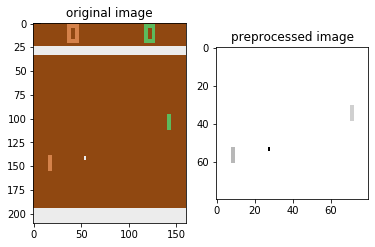

In [10]:
# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()

# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F



# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
        
        # 80x80 to outputsize x outputsize
        # outputsize = (inputsize - kernel_size + stride)/stride 
        # (round up if not an integer)
        self.conv1 = nn.Conv2d(2, 4, kernel_size=5, stride=2, padding=2)
        #self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # output = 40x40 here
        self.conv2 = nn.Conv2d(4, 16, kernel_size=5, stride=2, padding=2)
        #self.pool2 = nn.MaxPool2d(kernel_size=4, stride=4, padding=0)
        # output = 20x20 here
        self.size=16*20*20
        
        # 2 fully connected layer
        self.fc1 = nn.Linear(self.size, 256)
        self.fc2 = nn.Linear(256, 1)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
    
        x = F.relu(self.conv1(x))
        #x = self.pool1(x)
        x = F.relu(self.conv2(x))
        #x = self.pool2(x)
        # flatten the tensor
        x = x.view(-1, self.size)
        x = self.fc1(x)
        x = self.fc2(x)
        return self.sig(x)

# run your own policy!
policy=Policy().to(device)
# policy=pong_utils.Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

In [12]:
policy

Policy(
  (conv1): Conv2d(2, 4, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(4, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (fc1): Linear(in_features=6400, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [13]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress

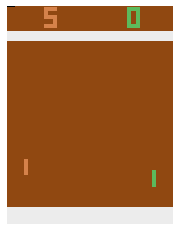

In [14]:
pong_utils.play(env, policy, time=100) 
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

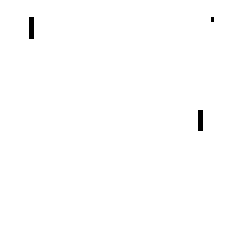

In [15]:
pong_utils.play(env, policy, time=100, preprocess=pong_utils.preprocess_single) 

# Rollout
Before we start the training, we need to collect samples. To make things efficient we use parallelized environments to collect multiple examples at once

In [16]:
envs = pong_utils.parallelEnv('PongDeterministic-v4', n=4, seed=12345)
prob, state, action, reward = pong_utils.collect_trajectories(envs, policy, tmax=100)

In [17]:
print(prob)

[array([0.49369252, 0.49362594, 0.50646967, 0.50640404], dtype=float32), array([0.5064076 , 0.4937721 , 0.5063176 , 0.50640404], dtype=float32), array([0.49365178, 0.49363568, 0.50624514, 0.4937261 ], dtype=float32), array([0.5063735 , 0.50636196, 0.49370646, 0.4935934 ], dtype=float32), array([0.49355796, 0.4937675 , 0.49366346, 0.49357992], dtype=float32), array([0.49365708, 0.49368206, 0.5064108 , 0.49365708], dtype=float32), array([0.5066366 , 0.49345216, 0.5067308 , 0.49336338], dtype=float32), array([0.49376458, 0.50623906, 0.5061149 , 0.49376458], dtype=float32), array([0.5062132 , 0.5062352 , 0.5061332 , 0.49378678], dtype=float32), array([0.5064477 , 0.50653994, 0.5063677 , 0.49355233], dtype=float32), array([0.5065327 , 0.49359652, 0.50650513, 0.49341503], dtype=float32), array([0.5062609 , 0.4935626 , 0.49361756, 0.49353758], dtype=float32), array([0.49373296, 0.5061854 , 0.49380922, 0.5062742 ], dtype=float32), array([0.49350476, 0.5065471 , 0.493432  , 0.50650024], dtype=f

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(what I call scalar function is the same as policy_loss up to a negative sign)

### PPO
Later on, you'll implement the PPO algorithm as well, and the scalar function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

In [18]:
def clipped_surrogate(policy, old_probs, states, actions, rewards,
                      discount = 0.995, epsilon=0.1, beta=0.01):

    ########
    ## 
    ## WRITE YOUR OWN CODE HERE
    ##
    ########
    discount = discount ** np.arange(len(rewards))
    rewards = np.asarray(rewards) * discount[:,np.newaxis]
    
    # convert rewards to future rewards
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10
    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]
    
    # convert to tensor
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)

    # convert states to policy (or probability)
    new_probs = pong_utils.states_to_prob(policy, states)
    new_probs = torch.where(actions == pong_utils.RIGHT, new_probs, 1.0-new_probs)
    
    ratio = new_probs / old_probs
    
    L = rewards * ratio
    L_clip = rewards * torch.clamp(ratio, 1-epsilon, 1+epsilon)

    # include a regularization term
    # this steers new_policy towards 0.5
    # prevents policy to become exactly 0 or 1 helps exploration
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))
    
    return torch.mean(torch.min(L, L_clip) + (beta * entropy))


Lsur= clipped_surrogate(policy, prob, state, action, reward)

print(Lsur)

tensor(0.0069, device='cuda:0', grad_fn=<MeanBackward0>)


# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [19]:
# keep track of how long training takes
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 1000 # 500

# widget bar to display progress
!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()


envs = pong_utils.parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
epsilon = 0.1
beta = .01
tmax = 320
SGD_epoch = 4

# keep track of progress
mean_rewards = []

policy.train()
for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)


    # gradient ascent step
    for _ in range(SGD_epoch):
        
        # uncomment to utilize your own clipped function!
        L = -clipped_surrogate(policy, old_probs, states, actions, rewards, 
                               discount=discount_rate, epsilon=epsilon, 
                               beta=beta)
        # L = -pong_utils.clipped_surrogate(policy, old_probs, states, actions, rewards,
        #                                   discount=discount_rate, epsilon=epsilon, 
        #                                   beta=beta)
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        #bar del L
    
    # the clipping parameter reduces as time goes on
    epsilon*=.999
    
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
policy.eval()
timer.finish()

Episode: 20, score: -14.500000
[-13. -10. -12. -16. -15. -17. -17. -16.]


Episode: 40, score: -14.750000
[-13. -16. -14. -16. -11. -16. -16. -16.]


Episode: 60, score: -15.125000
[-15. -16. -11. -17. -17. -16. -15. -14.]


Episode: 80, score: -14.500000
[-14. -16. -14. -14. -15. -16. -15. -12.]


Episode: 100, score: -13.875000
[-12. -16. -15. -12. -15. -12. -14. -15.]


Episode: 120, score: -11.875000
[-10. -11.  -9.  -9. -16. -12. -16. -12.]


Episode: 140, score: -10.500000
[-10. -12. -14.  -8. -10.  -9.  -8. -13.]


Episode: 160, score: -9.875000
[-10. -16. -10.  -6. -12.  -9.  -6. -10.]


Episode: 180, score: -7.375000
[ -8.  -1. -11.  -6.  -4. -13.  -9.  -7.]


Episode: 200, score: -6.250000
[-10.  -4.  -4.  -6.  -5.  -9.  -8.  -4.]


Episode: 220, score: -4.625000
[ -4.  -4.  -5.  -7.  -3. -10.  -3.  -1.]


Episode: 240, score: -3.000000
[-1. -8. -5. -3. -2. -3. -3.  1.]


Episode: 260, score: -3.750000
[-2. -3. -6. -5. -8. -2. -1. -3.]


Episode: 280, score: -2.750000
[-2. -1. -5. -2. -4. -1. -5. -2.]


Episode: 300, score: -3.000000
[ -1.   0.  -1.  -1. -13.  -6.  -2.   0.]


Episode: 320, score: -1.500000
[ 2. -1. -2. -5. -1. -1. -3. -1.]


Episode: 340, score: -1.625000
[-1. -1. -5. -2. -1. -1. -1. -1.]


Episode: 360, score: -0.875000
[-4. -1. -1. -1. -1.  1. -1.  1.]


Episode: 380, score: -1.250000
[-1. -3.  0. -1.  0. -1.  0. -4.]


Episode: 400, score: -1.500000
[-1.  0.  0.  0. -3. -4. -1. -3.]


Episode: 420, score: -1.250000
[-3. -1.  0.  0. -1. -3.  0. -2.]


Episode: 440, score: -1.375000
[-1.  0. -1. -5. -1.  0. -1. -2.]


Episode: 460, score: 0.000000
[ 1.  2. -1.  1. -4. -1.  0.  2.]


Episode: 480, score: 0.625000
[ 0.  1.  0.  2.  0.  0.  3. -1.]


Episode: 500, score: 0.750000
[ 1.  1.  1. -2.  3.  1.  1.  0.]


Episode: 520, score: 0.375000
[-2.  1.  3. -1.  0.  3.  0. -1.]


Episode: 540, score: 2.250000
[ 3.  3.  0.  2. -1.  3.  5.  3.]


Episode: 560, score: 2.375000
[ 3. -2.  3.  5.  1.  3.  3.  3.]


Episode: 580, score: 1.250000
[ 5. -3.  3. -2.  1.  3.  5. -2.]


Episode: 600, score: 3.625000
[1. 5. 5. 5. 5. 4. 2. 2.]


Episode: 620, score: 3.750000
[5. 5. 3. 5. 1. 3. 5. 3.]


Episode: 640, score: 4.750000
[5. 3. 5. 5. 5. 5. 5. 5.]


Episode: 660, score: 3.625000
[ 5.  1.  3.  7.  5. -2.  5.  5.]


Episode: 680, score: 5.125000
[7. 5. 5. 5. 5. 5. 5. 4.]


Episode: 700, score: 4.750000
[3. 5. 5. 5. 5. 5. 5. 5.]


Episode: 720, score: 3.625000
[ 7.  5.  3.  5.  5.  5.  1. -2.]


Episode: 740, score: 4.625000
[5. 0. 5. 5. 7. 5. 5. 5.]


Episode: 760, score: 5.000000
[5. 5. 5. 5. 3. 7. 5. 5.]


Episode: 780, score: 3.500000
[ 5.  2.  5.  3. -2.  5.  5.  5.]


Episode: 800, score: 4.500000
[3. 5. 3. 3. 7. 5. 5. 5.]


Episode: 820, score: 5.500000
[5. 5. 5. 7. 5. 7. 5. 5.]


Episode: 840, score: 5.250000
[5. 5. 5. 5. 5. 5. 5. 7.]


Episode: 860, score: 4.625000
[5. 0. 7. 5. 5. 5. 5. 5.]


Episode: 880, score: 3.500000
[ 5. -3.  5.  5.  5.  3.  5.  3.]


Episode: 900, score: 4.875000
[5. 5. 5. 5. 5. 5. 5. 4.]


Episode: 920, score: 4.125000
[ 5.  5.  5.  5. -2.  5.  5.  5.]


Episode: 940, score: 5.500000
[7. 7. 5. 5. 5. 5. 5. 5.]


Episode: 960, score: 4.875000
[0. 5. 5. 7. 5. 7. 5. 5.]


Episode: 980, score: 4.875000
[7. 5. 7. 5. 5. 5. 0. 5.]


Episode: 1000, score: 5.250000
[5. 7. 5. 5. 5. 5. 5. 5.]


#### CPU Load

![PPO CPU Load](./images/ppo-cpu-load.png)

#### GPU Load

```
while sleep 0.2; do
nvidia-smi --query-gpu=name,index,temperature.gpu,\
utilization.gpu,utilization.memory,\
memory.total,memory.free,memory.used --format=csv,noheader
done
```

```
GeForce GTX 1060, 0, 71, 4 %, 1 %, 6078 MiB, 3969 MiB, 2109 MiB
GeForce GTX 1060, 0, 71, 4 %, 1 %, 6078 MiB, 3969 MiB, 2109 MiB
GeForce GTX 1060, 0, 72, 82 %, 34 %, 6078 MiB, 3969 MiB, 2109 MiB
GeForce GTX 1060, 0, 73, 99 %, 32 %, 6078 MiB, 3969 MiB, 2109 MiB
GeForce GTX 1060, 0, 72, 68 %, 23 %, 6078 MiB, 3969 MiB, 2109 MiB
GeForce GTX 1060, 0, 72, 4 %, 1 %, 6078 MiB, 3969 MiB, 2109 MiB
GeForce GTX 1060, 0, 72, 5 %, 1 %, 6078 MiB, 3969 MiB, 2109 MiB
GeForce GTX 1060, 0, 72, 4 %, 1 %, 6078 MiB, 3969 MiB, 2109 MiB
GeForce GTX 1060, 0, 72, 4 %, 1 %, 6078 MiB, 3969 MiB, 2109 MiB
GeForce GTX 1060, 0, 72, 4 %, 1 %, 6078 MiB, 3969 MiB, 2109 MiB
GeForce GTX 1060, 0, 72, 5 %, 1 %, 6078 MiB, 3969 MiB, 2109 MiB
GeForce GTX 1060, 0, 72, 7 %, 2 %, 6078 MiB, 3969 MiB, 2109 MiB
GeForce GTX 1060, 0, 72, 14 %, 3 %, 6078 MiB, 3969 MiB, 2109 MiB
GeForce GTX 1060, 0, 72, 5 %, 1 %, 6078 MiB, 3969 MiB, 2109 MiB
GeForce GTX 1060, 0, 72, 4 %, 1 %, 6078 MiB, 3969 MiB, 2109 MiB
GeForce GTX 1060, 0, 72, 5 %, 1 %, 6078 MiB, 3969 MiB, 2109 MiB
GeForce GTX 1060, 0, 72, 8 %, 1 %, 6078 MiB, 3969 MiB, 2109 MiB
GeForce GTX 1060, 0, 72, 5 %, 2 %, 6078 MiB, 3969 MiB, 2109 MiB
GeForce GTX 1060, 0, 73, 54 %, 18 %, 6078 MiB, 3969 MiB, 2109 MiB
GeForce GTX 1060, 0, 73, 98 %, 39 %, 6078 MiB, 3969 MiB, 2109 MiB
GeForce GTX 1060, 0, 73, 68 %, 23 %, 6078 MiB, 3969 MiB, 2109 MiB
GeForce GTX 1060, 0, 72, 4 %, 1 %, 6078 MiB, 3969 MiB, 2109 MiB
GeForce GTX 1060, 0, 72, 4 %, 1 %, 6078 MiB, 3969 MiB, 2109 MiB
```

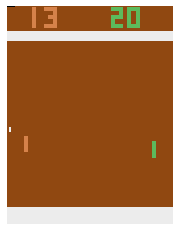

In [20]:
# play game after training!
pong_utils.play(env, policy, time=2000)

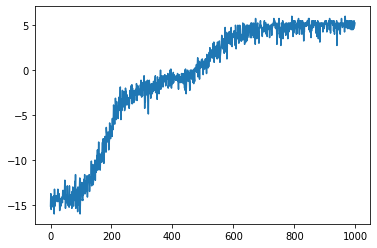

In [21]:
plt.plot(mean_rewards)

In [23]:
# save your policy!
torch.save(policy, 'pong-PPO.policy')

# load policy if needed
# policy = torch.load('pong-PPO.policy')

# try and test out the solution!
# policy = torch.load('pong-PPO_solution.policy')

# try and test out the solution 
# make sure GPU is enabled, otherwise loading will fail
# (the PPO verion can win more often than not)!
#
# policy_solution = torch.load('PPO_solution.policy')
# pong_utils.play(env, policy_solution, time=2000) 

## Watch a Smart Agent!

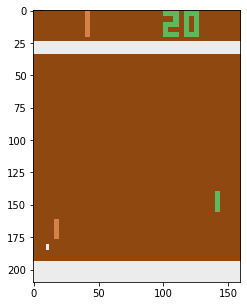

In [24]:
time=2000
nrand=5

plt.figure(figsize=(5,5))
state = env.reset()
env.step(1)
img = plt.imshow(env.render(mode='rgb_array')) # only call this once

# perform nrand random steps in the beginning
for _ in range(nrand):
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    env.render()
    frame1, reward1, is_done, _ = env.step(np.random.choice(
        [pong_utils.RIGHT,pong_utils.LEFT]))
    frame2, reward2, is_done, _ = env.step(0)

for _ in range(time):
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    frame_input = pong_utils.preprocess_batch([frame1, frame2])
    prob = policy(frame_input)

    env.render()
    # RIGHT = 4, LEFT = 5
    action = pong_utils.RIGHT if rand.random() < prob else pong_utils.LEFT
    frame1, _, is_done, _ = env.step(action)
    frame2, _, is_done, _ = env.step(0)

    if is_done:
        break

env.close()

In [25]:
time=2000
nrand=5

env = wrappers.Monitor(env, "./gym-results-PPO", force=True)
state = env.reset()
env.step(1)
# perform nrand random steps in the beginning
for _ in range(nrand):
    env.render()
    frame1, reward1, is_done, _ = env.step(np.random.choice(
        [pong_utils.RIGHT,pong_utils.LEFT]))
    frame2, reward2, is_done, _ = env.step(0)

for _ in range(time):
    frame_input = pong_utils.preprocess_batch([frame1, frame2])
    prob = policy(frame_input)

    env.render()
    # RIGHT = 4, LEFT = 5
    action = pong_utils.RIGHT if rand.random() < prob else pong_utils.LEFT
    frame1, _, is_done, _ = env.step(action)
    frame2, _, is_done, _ = env.step(0)

    if is_done:
        break

env.close()

Convert mp4 file to GIF.

In [26]:
%%bash
ls -l ./gym-results-PPO

total 152
-rw-r--r-- 1 eka eka    160 Oct 10 06:08 openaigym.episode_batch.0.22339.stats.json
-rw-r--r-- 1 eka eka    234 Oct 10 06:08 openaigym.manifest.0.22339.manifest.json
-rw-r--r-- 1 eka eka   2125 Oct 10 06:08 openaigym.video.0.22339.video000000.meta.json
-rw-r--r-- 1 eka eka 141311 Oct 10 06:08 openaigym.video.0.22339.video000000.mp4


In [27]:
%%bash
ffmpeg -i ./gym-results-PPO/openaigym.video.0.22339.video000000.mp4 ./gifs-PPO/001.gif

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

## Hardware Specifications and Software Versions

In [28]:
%%bash
cat /etc/os-release

NAME="Ubuntu"
VERSION="18.04.3 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.3 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=bionic
UBUNTU_CODENAME=bionic


In [29]:
%%bash
nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [30]:
%%bash
nvidia-smi

Thu Oct 10 04:41:54 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1060    Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   58C    P3    24W /  N/A |   1703MiB /  6078MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [31]:
%%bash
pip freeze

atari-py==0.2.6
attrs==19.1.0
backcall==0.1.0
bleach==3.1.0
box2d-py==2.3.8
certifi==2019.6.16
cffi==1.12.3
cloudpickle==1.2.2
cycler==0.10.0
Cython==0.29.13
decorator==4.4.0
defusedxml==0.6.0
entrypoints==0.3
future==0.17.1
glfw==1.8.3
gym==0.14.0
imageio==2.5.0
ipykernel==5.1.2
ipython==7.8.0
ipython-genutils==0.2.0
ipywidgets==7.5.1
jedi==0.15.1
Jinja2==2.10.1
jsonschema==3.0.2
jupyter==1.0.0
jupyter-client==5.3.1
jupyter-console==6.0.0
jupyter-core==4.5.0
kiwisolver==1.1.0
lockfile==0.12.2
MarkupSafe==1.1.1
matplotlib==3.1.1
mistune==0.8.4
mkl-fft==1.0.14
mkl-random==1.0.2
mkl-service==2.3.0
mujoco-py==2.0.2.5
nbconvert==5.5.0
nbformat==4.4.0
notebook==6.0.1
numpy==1.16.5
olefile==0.46
opencv-python==4.1.1.26
pandocfilters==1.4.2
parso==0.5.1
pexpect==4.7.0
pickleshare==0.7.5
Pillow==6.1.0
progressbar==2.5
prometheus-client==0.7.1
prompt-toolkit==2.0.9
ptyprocess==0.6.0
pycparser==2.19
pyglet==1.3.2
Pygments==2.4.2
pyparsing==2.4.2
pyrsistent==0.14.11
python-dateutil==2.8.0
pytz==2